In [1]:
import copy
from collections import defaultdict, Counter
import json
import pickle

import numpy as np
import matplotlib.pyplot as plt
import torch

# arc train/val datasets

In [2]:
base_path='./data/'
def load_json(file_path):
    with open(file_path) as f:
        data = json.load(f)
    return data

In [3]:
training_challenges   = load_json(base_path + 'arc-agi_training_challenges.json')
training_solutions    = load_json(base_path + 'arc-agi_training_solutions.json')

evaluation_challenges = load_json(base_path + 'arc-agi_evaluation_challenges.json')
evaluation_solutions  = load_json(base_path + 'arc-agi_evaluation_solutions.json')

# test_challenges       = load_json(base_path + 'arc-agi_test_challenges.json')

In [4]:
def merge_challenges_with_solutions(challenges, solutions):
    merge = copy.deepcopy(challenges)
    for key, task in challenges.items():
        merge[key]['test'] = []
        test_inputs = task['test']
        test_outputs = solutions[key]
        for input, output in zip(test_inputs, test_outputs):
            merge[key]['test'].append(
                {
                    'input': input['input'],
                    'output': output,
                }
            )
    return merge


train_tasks = merge_challenges_with_solutions(training_challenges, training_solutions)
val_tasks = merge_challenges_with_solutions(evaluation_challenges, evaluation_solutions)
# test_tasks = test_challenges

print('num train tasks:', len(train_tasks))
print('num val tasks:', len(val_tasks))
# print('num test tasks:', len(test_tasks))

num train tasks: 400
num val tasks: 400


In [5]:
def filter_by_board_size(tasks, max_numel=100):
    filtered_tasks = defaultdict(dict)
    for key, task in tasks.items():
        valid_train_task_ids = []
        for i, sample in enumerate(task['train']):
            if np.size(sample['input']) > max_numel:
                continue
            else:
                valid_train_task_ids.append(i)
        if not valid_train_task_ids:
            continue

        filtered_tasks[key]['train'] = [task['train'][valid_id] for valid_id in valid_train_task_ids]
        filtered_tasks[key]['test'] = copy.deepcopy(task['test'])

    return dict(filtered_tasks)


small_train_tasks = filter_by_board_size(train_tasks, max_numel=50)
small_val_tasks = filter_by_board_size(val_tasks, max_numel=50)

print('num train tasks before filtering:', len(train_tasks))
print('num train tasks after filtering:', len(small_train_tasks))
print('num val tasks before filtering:', len(val_tasks))
print('num val tasks after filtering:', len(small_val_tasks))

num train tasks before filtering: 400
num train tasks after filtering: 145
num val tasks before filtering: 400
num val tasks after filtering: 103


In [6]:
def _flatten_board(board):
    flat_board = [pixel for row in board for pixel in row]
    return flat_board


def get_color_stats(tasks):
    c = Counter()
    for task_key, task_samples in tasks.items():
        c.update(set(_flatten_board(task_samples['test'][0]['output'])))
    return c


color_stats = {
    'train': get_color_stats(train_tasks),
    'small_train': get_color_stats(small_train_tasks),
    'val': get_color_stats(val_tasks),
    'small_val': get_color_stats(small_val_tasks),
}

for key, stats in color_stats.items():
    print('%-10s' % key, end='\t')
    print(', '.join(map(str, [{color_id: stats[color_id]} for color_id in range(10)])))

train     	{0: 313}, {1: 171}, {2: 193}, {3: 165}, {4: 150}, {5: 95}, {6: 87}, {7: 62}, {8: 160}, {9: 44}
small_train	{0: 109}, {1: 51}, {2: 56}, {3: 58}, {4: 46}, {5: 35}, {6: 33}, {7: 24}, {8: 47}, {9: 16}
val       	{0: 322}, {1: 203}, {2: 240}, {3: 198}, {4: 171}, {5: 109}, {6: 127}, {7: 97}, {8: 202}, {9: 51}
small_val 	{0: 85}, {1: 39}, {2: 50}, {3: 38}, {4: 33}, {5: 26}, {6: 30}, {7: 21}, {8: 34}, {9: 12}


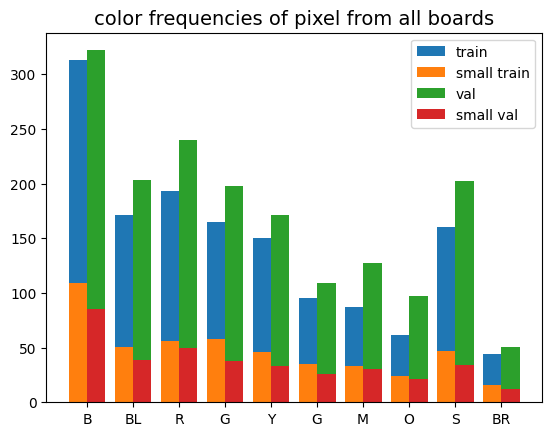

In [7]:
color_map = ['B', 'BL', 'R', 'G', 'Y', 'G', 'M', 'O', 'S', 'BR']

plt.bar(np.arange(10), [color_stats['train'][i] for i in range(10)], label='train', width=0.4)
plt.bar(np.arange(10), [color_stats['small_train'][i] for i in range(10)], label='small train', width=0.4)

plt.bar(np.arange(10) + 0.4, [color_stats['val'][i] for i in range(10)], label='val', width=0.4)
plt.bar(np.arange(10) + 0.4, [color_stats['small_val'][i] for i in range(10)], label='small val', width=0.4)
plt.xticks(ticks=np.arange(10) + 0.2, labels=color_map)
plt.legend()

plt.title('color frequencies of pixel from all boards', fontsize=14)
plt.show()

In [8]:
class SimpleTokenizer:
    def __init__(self):
        self.pixel_tokens = list(range(10))
        self.in_out_sep_token = '[:]'
        self.sep_token = '[SEP]'
        self.mask_token = '[MASK]'
        self.pad_token = '[PAD]'
        self.special_tokens = [self.in_out_sep_token, self.sep_token, self.mask_token, self.pad_token]

        self.token_to_id = {token: i for i, token in enumerate(self.pixel_tokens + self.special_tokens)}

        self.id_to_token = {v: k for k, v in self.token_to_id.items()}

        self.in_out_sep_token_id = self.token_to_id[self.in_out_sep_token]
        self.sep_token_id = self.token_to_id[self.sep_token]
        self.mask_token_id = self.token_to_id[self.mask_token]
        self.pad_token_id = self.token_to_id[self.pad_token]

    def encode(self, seq):
        return [self.token_to_id[token] for token in seq]

    def decode(self, ids):
        return [self.id_to_token[i] for i in ids]

    def __len__(self):
        return len(self.token_to_id)


tokenizer = SimpleTokenizer()

In [9]:
def _prepare_input_seqs(task, train=True):
    input_train_seq = []
    for sample in task['train']:
        input_train_seq += _flatten_board(sample['input'])
        input_train_seq += [tokenizer.in_out_sep_token]
        input_train_seq += _flatten_board(sample['output'])
        input_train_seq += [tokenizer.sep_token]

    input_test_seq = []

    # there is single input for test
    test_sample = task['test'][0]

    input_test_seq += _flatten_board(test_sample['input'])
    input_test_seq += [tokenizer.in_out_sep_token]

    input_seq = input_train_seq + input_test_seq

    if train:
        assert test_sample['output'] is not None
        target_seq = [tokenizer.pad_token for _ in range(len(input_seq))]
        target_seq += _flatten_board(test_sample['output'])

        input_seq += [tokenizer.pad_token for _ in range(len(target_seq) - len(input_seq))]
        return {
            'input': input_seq,
            'target': target_seq,
        }
    else:
        input_seq += [tokenizer.pad_token for _ in range(1000)]
        return {
            'input': input_seq,
        }

In [10]:
class ARCDataset(torch.utils.data.Dataset):
    def _split_task_to_one_test_per_train(self, task):
        if len(task['test']) == 1:
            return [task]

        common_train = task['train']
        new_tasks = []
        for sample in task['test']:
            one_new_task = {'train': common_train, 'test': []}
            one_new_task['test'] = [
                {
                    'input': sample['input'],
                    'output': sample.get('output', None),
                }
            ]
            new_tasks.append(one_new_task)
        return new_tasks

    def __init__(self, named_tasks, tokenizer, augment=True, train=True):
        # split tasks to one out per input
        keys = []
        tasks = []
        for key, task in named_tasks.items():
            splitted_tasks = self._split_task_to_one_test_per_train(task)

            tasks.extend(splitted_tasks)
            keys.extend([key for _ in splitted_tasks])

        self.keys = keys
        self.tasks = tasks

        self.tokenizer = tokenizer
        self.augment = augment
        self.train = train

    def __len__(self):
        return len(self.keys)

    def __getitem__(self, idx):
        # outputs list of items per call

        key = self.keys[idx]
        task = self.tasks[idx]

        if self.augment:
            augmented_task, augmentation = apply_random_augmentation(task)
            augmented_key = key + '|' + augmentation.__name__
        else:
            augmented_task = task
            augmented_key = (key + '|' + 'identity')

        input_seqeunce = _prepare_input_seqs(augmented_task, train=self.train)

        input_tokens = {k: self.tokenizer.encode(s) for k, s in input_seqeunce.items()}

        return augmented_key, input_tokens


val_dataset = ARCDataset(val_tasks, tokenizer, augment=False, train=False)
small_val_dataset = ARCDataset(small_val_tasks, tokenizer, augment=False, train=False)

In [11]:
def get_lengths(dataset):
    lengths = []
    for _, sample in dataset:
        lengths.append(len(sample['input']))
    return lengths


val_lengths = get_lengths(val_dataset)
small_val_lengths = get_lengths(small_val_dataset)

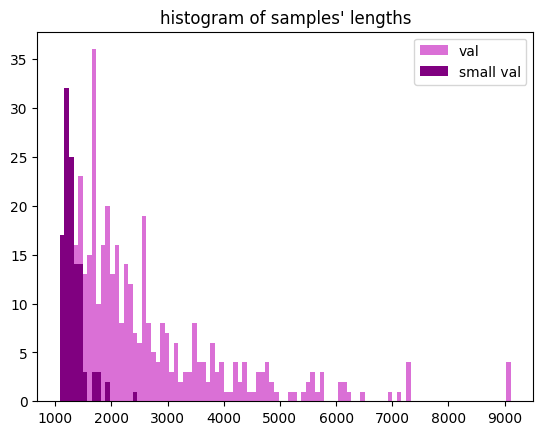

In [12]:
bins = np.linspace(min(val_lengths), max(val_lengths), num=100)

plt.hist(val_lengths, bins=bins, label='val', color='orchid')
plt.hist(small_val_lengths, bins=bins, label='small val', color='purple')
plt.legend()

plt.title("histogram of val samples' lengths")

plt.show()

# re arc sampled dataset

In [13]:
class ReARCSampledDataset(torch.utils.data.Dataset):
    def __init__(self, datapath, tokenizer, augment=True):
        print('loading data.', end=' ')
        with open(datapath, 'rb') as f:
            data = pickle.load(f)
        print('done')

        self.data = data

        keys = []
        samples = []
        for task_key, task_samples in data.items():
            keys.extend([task_key for _ in range(len(task_samples))])
            samples.extend(task_samples)
        self.keys = keys
        self.samples = samples

        self.tokenizer = tokenizer
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        key = self.keys[idx]
        sample = self.samples[idx]

        if self.augment:
            augmented_sample, augmentation = apply_random_augmentation(sample)
            augmented_key = key + '|' + augmentation.__name__
        else:
            augmented_sample = sample
            augmented_key = (key + '|' + 'identity')

        input_seqeunce = _prepare_input_seqs(augmented_sample, train=True)

        input_tokens = {k: self.tokenizer.encode(s) for k, s in input_seqeunce.items()}

        return augmented_key, input_tokens

In [14]:
train_dataset = ReARCSampledDataset('data/rearc1M.pkl', tokenizer, augment=False)

small_train_dataset_ids = [i for i, (_, input_tokens) in enumerate(train_dataset) if len(input_tokens['input']) < 2500]

small_train_dataset = torch.utils.data.Subset(train_dataset, small_train_dataset_ids)

print('num train samples:', len(train_dataset))
print('num small train samples:', len(small_train_dataset))

loading data. done
num train samples: 1000000
num small train samples: 1000000


In [19]:
def get_color_stats_re(samples):
    c = Counter()
    for task_samples in samples:
        c.update(set(_flatten_board(task_samples['test'][0]['output'])))
    return c


color_stats = {
    'train': get_color_stats_re(train_dataset.samples),
    # 'small_train': get_color_stats([train_dataset.samples[idx] for idx in small_train_dataset_ids]),
}

for key, stats in color_stats.items():
    print('%-10s' % key, end='\t')
    print(', '.join(map(str, [{color_id: stats[color_id]} for color_id in range(10)])))

train     	{0: 260017}, {1: 267628}, {2: 290463}, {3: 261667}, {4: 244186}, {5: 221084}, {6: 218930}, {7: 214305}, {8: 250177}, {9: 209910}


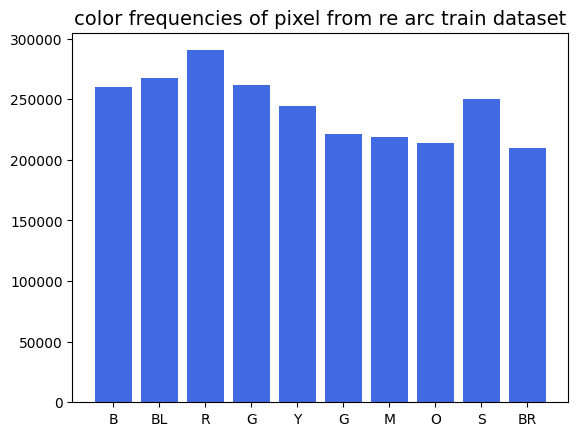

In [21]:
color_map = ['B', 'BL', 'R', 'G', 'Y', 'G', 'M', 'O', 'S', 'BR']

plt.bar(np.arange(10), [color_stats['train'][i] for i in range(10)], color='royalblue')
plt.xticks(ticks=np.arange(10), labels=color_map)

plt.title('color frequencies of pixel from re arc train dataset', fontsize=14)
plt.show()

In [22]:
train_lengths = get_lengths(train_dataset)
# small_train_lengths = get_lengths(small_train_dataset)

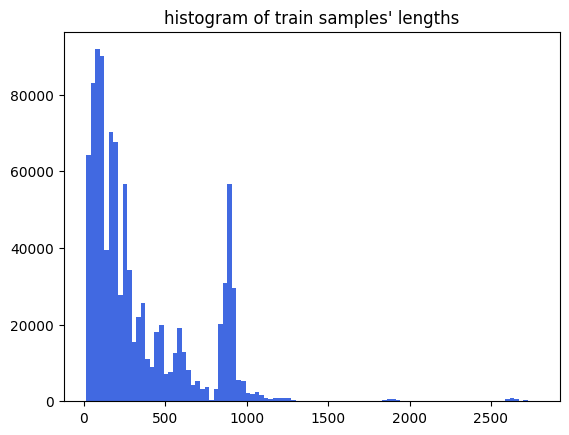

In [23]:
bins = np.linspace(min(train_lengths), max(train_lengths), num=100)

plt.hist(train_lengths, bins=bins, color='royalblue')
# plt.hist(small_train_lengths, bins=bins, label='small train', color='mediumblue')
# plt.legend()

plt.title("histogram of train samples' lengths")

plt.show()

In [24]:
max(train_lengths)

2783